In [16]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import ccdproc as ccdp

from astropy.nddata import CCDData
from astropy.stats import mad_std
import astropy.units as u
from convenience_functions import show_image

# suppress warnings is not recommended :I
import warnings
warnings.filterwarnings("ignore")

bias_dir = './data/bias'
flat_dir = './data/flat'
darks_dir = './data/dark'
tzboo_dir = './data/tz_boo'
cccom_dir = './data/cc_com'

# Responses to the Data Reduction & Photometry Lab
## 1. Define the bias. Include both a description of what it looks like physically, why it occurs, and how we take it into account (how do we remove its effect on our data images?)

A bias contains a grid of values added to every pixel on the CCD to ensure no negative pixel values are output. A bias value to a pixel can be likened to adjusting the y-intercept of a linear function. We expect to account for negative pixel counts because reading noise can be modeled as a Gaussian distribution with a mean of zero and some standard deviation. The read noise comes from material imperfections of the CCD. Ideally, a bias would be uniform across all CCD pixels.

In practice, biases are offset voltages. To take a bias of a given CCD instrument, one reads out the CCD with zero exposure time. 

## 2. Why would we use more than one bias frame?

The noise reduction factor goes like $\sim 1/\sqrt{N}$, with $N$ as the number of combined biases to be combined. Having multiple biases thus increases the amount the noise is reduced

## 3. List the average value of each of your bias frames, as well as your final master bias.

In [ ]:
biases = ImageFileCollection(bias_dir).files_filtered(imagetyp='bias', include_path=True)

combined_bias = ccdp.combine(biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6,
                             unit='adu'
                            );
combined_bias.write(bias_dir + '/combined_bias.fits')

In [26]:
reduced_biases = ImageFileCollection(bias_dir).files_filtered(imagetyp='bias', include_path=True)
for bias in reduced_biases:
    mean = CCDData.read(bias, unit='adu').data.mean()
    print(f'mean for {bias}: {mean:.3f}')
    
    
combined_bias = CCDData.read(bias_dir + '/combined_bias.fits')
print('combined mean: ' + str(combined_bias.data.mean()))

mean for ./data/bias/Bias_BIN1_20230424_031732.fits: 980.423
mean for ./data/bias/Bias_BIN1_20230424_031823.fits: 980.209
mean for ./data/bias/Bias_BIN1_20230424_031904.fits: 980.381
mean for ./data/bias/Bias_BIN1_20230424_031946.fits: 980.619
mean for ./data/bias/Bias_BIN1_20230424_032028.fits: 980.514
mean for ./data/bias/Bias_BIN1_20230424_032109.fits: 980.559
mean for ./data/bias/Bias_BIN1_20230424_032152.fits: 980.830


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
mean for ./data/bias/combined_bias.fits: 980.505
combined mean: 980.5052719468449


## 4. Define “overscan”

An overscan is the covered portion of the CCD sensor. This feature is useful in removing variations in the bias on a frame-by-frame basis. Data from the overscan includes bias, read noise, and dark current.

## 5. List your overscan parameters. (Where is the overscan on your images?)

ARCSAT images have no overscan.

## 6. Which filters do you have flat fields for? List the flat field file names for each filter that you need. Do you have more flats than you need? Confirm that your flat fields have the same binning as your data.

Our project took flat fields for B and V filters. Both observation images and flats have 1x1 binning. The files include:

In [ ]:
flats = ImageFileCollection(flat_dir)
flats.summary['file', 'xbinning', 'ybinning']

In [ ]:
tz_boo = ImageFileCollection(tzboo_dir)
tz_boo.summary['file', 'xbinning', 'ybinning']

In [ ]:
cc_com = ImageFileCollection(cccom_dir)
cc_com.summary['file', 'xbinning', 'ybinning']

## 7. Why do we need flat fields for each filter we have used for observations?
Flats involve reading data taken from a controlled source of light. They are taken to correct for visual artifacts like vignetting, dust on the CCD, etc. We need to make flat fields for each filter as the CCD sensor's response depends on the wavelength of incident photons.

- BIAS SUBTRACTION AND FLAT FIELD NORMALIZATION SHOULD BE DONE ON EACH OF
YOUR OBJECT IMAGE FILES. It is a good place to take a little time and develop a loop, or a
small pseudo pipeline

- To do: flat field normalization

## We actually need to process darks first lol

In [18]:
bias_data = CCDData.read(bias_dir + '/combined_bias.fits')

In [19]:
rawdarks_collection = ImageFileCollection(darks_dir + '/raw')
darks = rawdarks_collection.summary['imagetyp'] == 'DARK'
dark_times = set(rawdarks_collection.summary['exptime'][darks])
print(dark_times)

{1800.0, 900.0}


In [21]:
exp_time = 900.0

for ccd, file_name in rawdarks_collection.ccds(imagetyp='DARK',
                                               exptime=exp_time,
                                               ccd_kwargs={'unit': 'adu'},
                                               return_fname=True):
    ccd = ccdp.subtract_bias(ccd, bias_data)
    ccd.write(darks_dir + '/reduced/' + file_name)

calibrated_darks = ImageFileCollection(darks_dir + '/reduced').files_filtered(imagetyp='DARK', include_path=True)
combined_dark = ccdp.combine(calibrated_darks,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combined_dark.meta['combined'] = True

dark_file_name = 'combined_dark_{:6.3f}.fit'.format(exp_time)
combined_dark.write(darks_dir + '/' + dark_file_name)

INFO:astropy:splitting each image into 5 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 5 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [22]:
for i in range(len(calibrated_darks)):
    print(calibrated_darks[i])
    data = CCDData.read(calibrated_darks[i]).data
    print(data.mean())

./data/dark/reduced/Dark_BIN1_20230422_092413.fits
15.442690691240465
./data/dark/reduced/Dark_BIN1_20230422_094008.fits
15.180672020562572
./data/dark/reduced/Dark_BIN1_20230422_095549.fits
14.921635103228894
./data/dark/reduced/dark900.fits
10.230446218090036


In [23]:
combined_dark = CCDData.read(darks_dir + '/combined_dark_900.000.fit')
combined_dark.data.mean()


13.709873445976351

To do list
- [x] subtract bias from flat
- [x] scale the dark
- [x] subtract dark from flat
- [ ] divide images by the flat

In [6]:
raw_V_flat = ImageFileCollection(flat_dir + '/V_raw')
combined_bias_data = CCDData.read(bias_dir + '/combined_bias.fits')
combined_dark_data = CCDData.read(darks_dir + '/combined_dark_900.000.fit')

for ccd, file_name in raw_V_flat.ccds(imagetyp='FLAT',
    ccd_kwargs={'unit': 'adu'}, return_fname=True):
    
    ccd = ccdp.subtract_bias(ccd, combined_bias_data)
    ccd = ccdp.subtract_dark(ccd, combined_dark_data,
                            exposure_time='exptime', exposure_unit=u.second, scale=True)
    
    ccd.write(flat_dir + '/V_reduced/' + file_name)
    

In [38]:
for ccd, file_name in ImageFileCollection(flat_dir + '/V_reduced').ccds(imagetyp='FLAT', return_fname=True):
    print(file_name)
    print(ccd.data.mean())
    
combined_V_flat = CCDData.read(flat_dir + '/combined_V_filter.fits')
print(combined_V_flat.data.mean())

domeflat_V_001.fits
17863.596565312222
domeflat_V_002.fits
18818.938065230042
domeflat_V_003.fits
18983.112236799752
0.99555731746377


In [7]:
cal_V_flats = ImageFileCollection(flat_dir + '/V_reduced').files_filtered(include_path=True)

def inv_median(a):
    return 1 / np.median(a)

combined_V_flat = ccdp.combine(cal_V_flats,
             scale=inv_median, sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
             mem_limit=350e6
            )

combined_V_flat.meta['combined'] = True
flat_file_name = 'combined_V_filter.fits'
combined_V_flat.write(flat_dir + '/' + flat_file_name)

    
    

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# Testing the stuff on an image

62.39660676640981

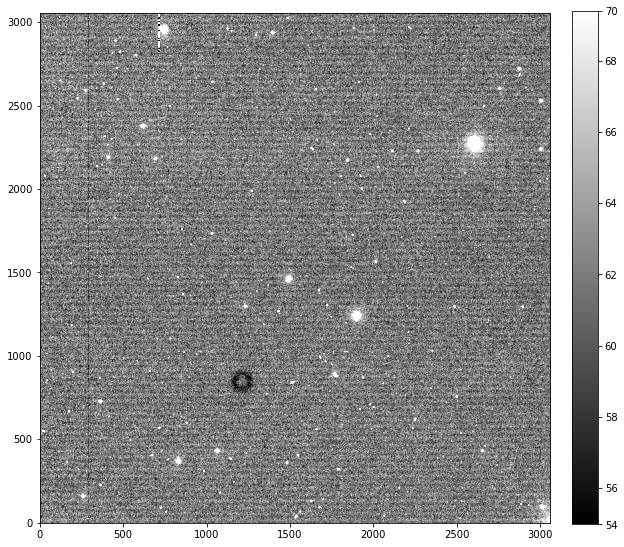

In [42]:
# sample = CCDData.read(cccom_dir + '/CC Com_V_2.fits', unit='adu')
sample = CCDData.read(tzboo_dir + '/TZ Boo_V_2.fits', unit='adu')
combined_bias_data = CCDData.read(bias_dir + '/combined_bias.fits')
combined_dark_data = CCDData.read(darks_dir + '/combined_dark_900.000.fit')
combined_V_flat = CCDData.read(flat_dir + '/combined_V_filter.fits')

reduced = ccdp.subtract_bias(sample, combined_bias_data)
reduced = ccdp.subtract_dark(reduced, combined_dark_data,
                            exposure_time='exptime', exposure_unit=u.second, scale=True)
reduced = ccdp.flat_correct(reduced, combined_V_flat)

# plt.imshow(np.log10(reduced.data), cmap='gray')
# plt.colorbar()

show_image(reduced.data, cmap='gray')
reduced.data.mean()

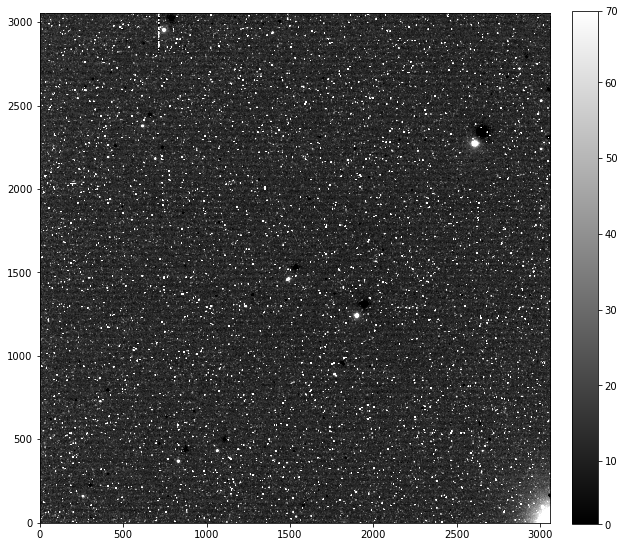

In [43]:
reduced_tommy = CCDData.read(tzboo_dir + '/TZ Boo_15s_V_2_20230505_043335_Tommy.fits')
difference = reduced.data - reduced_tommy.data
show_image(difference, cmap='gray')

In [30]:
difference.mean()

16.443727484492637

In [31]:
reduced.data.mean()

62.41449619048306

In [32]:
reduced_tommy.data.mean()

45.97076870599043

In [12]:
combined_bias_data.data.mean()

980.5052719468449

In [13]:
combined_dark_data.data.mean()

12.650245260528234

In [14]:
combined_V_flat.data.mean()

0.99555731746377

In [12]:
import matplotlib

matplotlib.rcParams['figure.dpi'] = 200

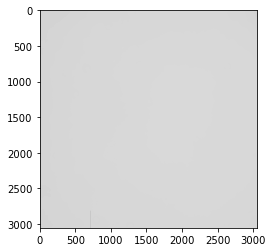